In [9]:
import pandas as pd
test_df = pd.read_pickle("FY26.pkl")
train_df = pd.read_pickle("FY24FY25.pkl")



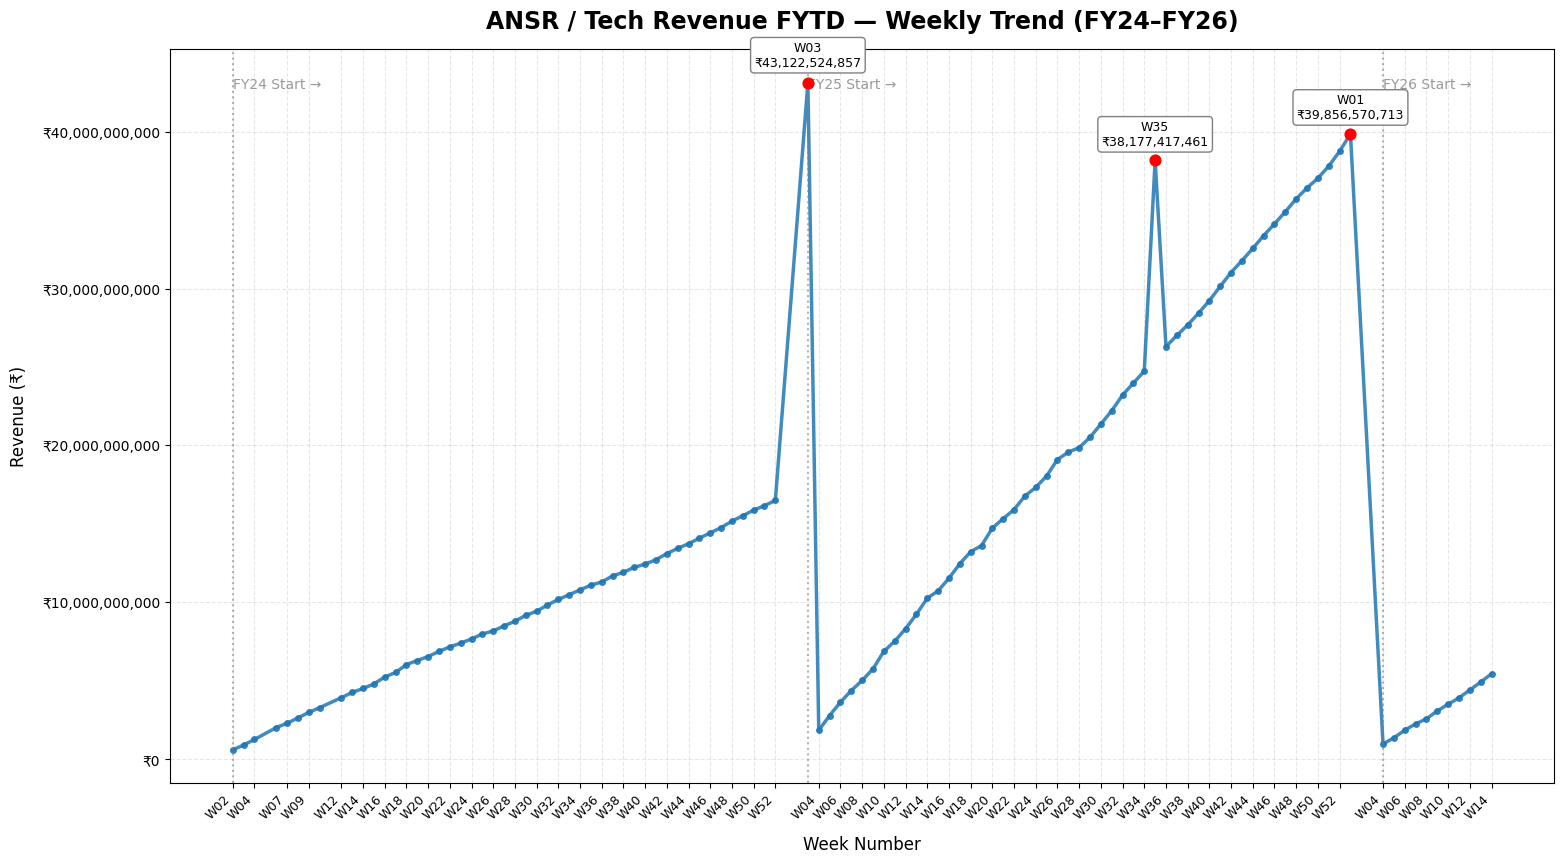

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# Combine training + test datasets
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Aggregate weekly ANSR values
weekly_data = (
    full_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Week"])
)

# Convert Year to numeric (FY24 → 2024)
weekly_data["Year_Num"] = (
    weekly_data["Year"]
    .astype(str)
    .str.extract(r"(\d+)")[0]
    .astype(int)
    + 2000
)

# Create Date column (Monday of each week)
weekly_data["Date"] = pd.to_datetime(
    weekly_data["Year_Num"].astype(str) + weekly_data["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

# Sort and index
weekly_data = weekly_data.sort_values("Date").set_index("Date")
ts = weekly_data["ANSR / Tech Revenue FYTD"]

# Detect peaks
peak_idx = np.where((ts.shift(1) < ts) & (ts.shift(-1) < ts))[0]
peaks = ts.iloc[peak_idx]

# 🎨 Plot with increased vertical height
plt.figure(figsize=(16,9))  # ⬅ Increased height from 7 → 9
plt.plot(ts.index, ts, color="#1f77b4", linewidth=2.5, marker='o', markersize=4, alpha=0.85)

# 🧭 X-axis: show only week numbers (every 2 weeks)
tick_idx = ts.index[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha="right", fontsize=9)

# 📊 Annotate peaks
for date, value in peaks.items():
    plt.scatter(date, value, color="red", s=60, zorder=5)
    plt.text(
        date, value * 1.02,  # slightly less height for balance
        f"W{date.isocalendar().week:02d}\n₹{value:,.0f}",
        ha='center', va='bottom',
        fontsize=9, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
    )

# 🧾 Y-axis formatting
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.0f}'))

# 🧩 Titles and labels
plt.title("ANSR / Tech Revenue FYTD — Weekly Trend (FY24–FY26)", fontsize=17, weight='bold', pad=15)
plt.xlabel("Week Number", fontsize=12, labelpad=10)
plt.ylabel("Revenue (₹)", fontsize=12, labelpad=10)

# 🌈 Grid and style
plt.grid(alpha=0.3, linestyle='--')

# Add Fiscal Year Start indicators
years = sorted(weekly_data["Year_Num"].unique())
for y in years:
    fy_weeks = weekly_data[weekly_data["Year_Num"] == y]
    if not fy_weeks.empty:
        start = fy_weeks.index.min()
        plt.axvline(start, color="gray", linestyle=":", alpha=0.6)
        plt.text(
            start, plt.ylim()[1]*0.94,  # adjusted position for taller figure
            f"FY{y-2000} Start →",
            rotation=0,
            fontsize=10, color="gray",
            ha="left", va="bottom", alpha=0.8
        )

plt.tight_layout(pad=2)
plt.show()


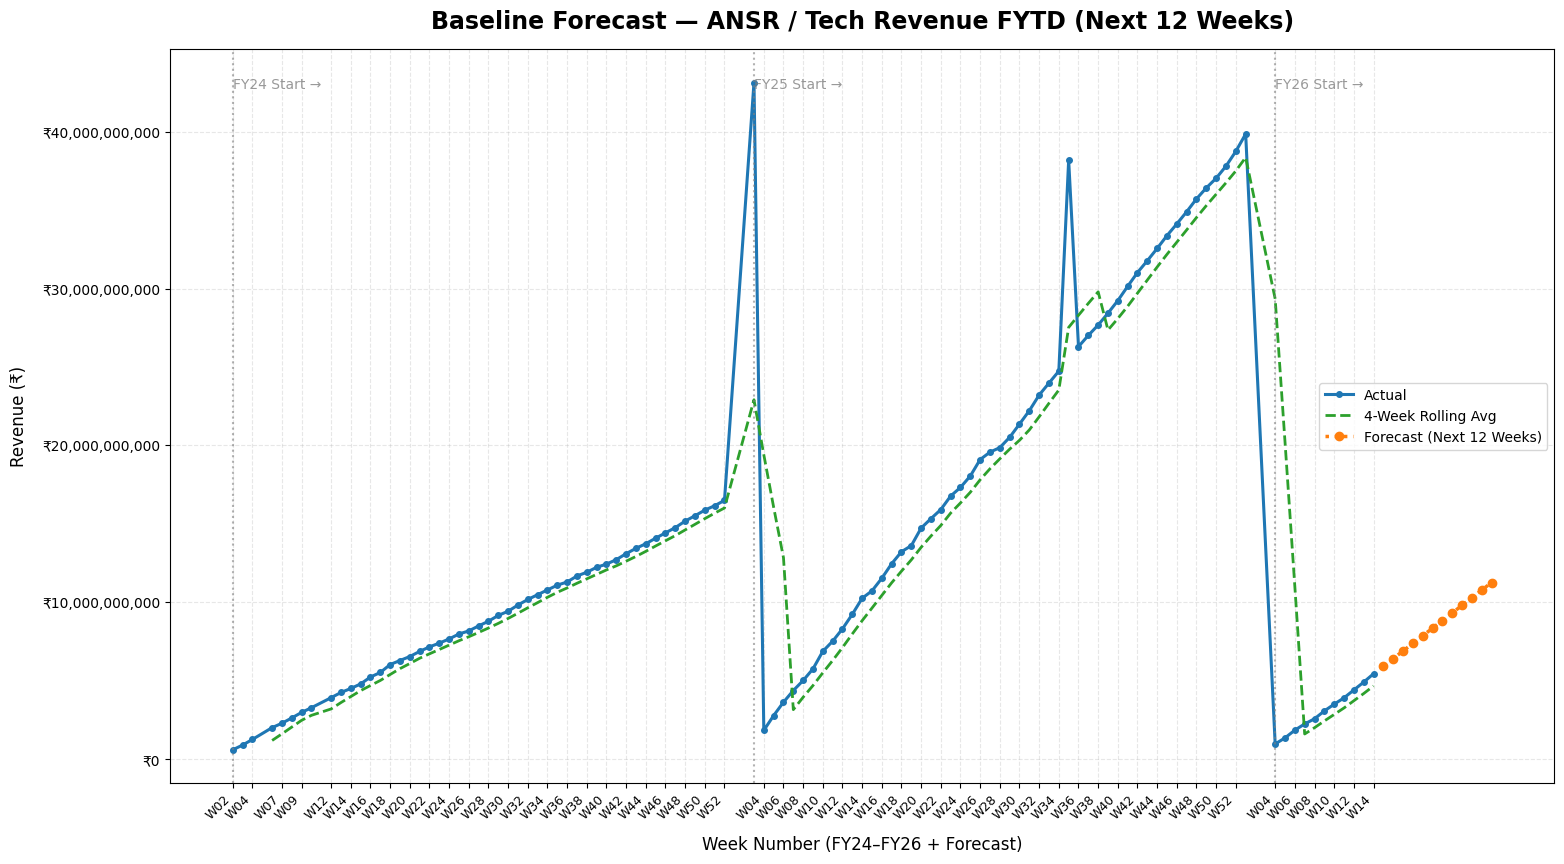

📋 Baseline 12-Week Forecast Table:

   Date     Week  Predicted FYTD Revenue (₹)
2026-04-06   15        5,923,802,127.25     
2026-04-13   16        6,408,551,553.32     
2026-04-20   17        6,893,300,979.39     
2026-04-27   18        7,378,050,405.46     
2026-05-04   19        7,862,799,831.53     
2026-05-11   20        8,347,549,257.60     
2026-05-18   21        8,832,298,683.67     
2026-05-25   22        9,317,048,109.75     
2026-06-01   23        9,801,797,535.82     
2026-06-08   24       10,286,546,961.89     
2026-06-15   25       10,771,296,387.96     
2026-06-22   26       11,256,045,814.03     

✅ Forecast table displayed successfully.


In [11]:
# =========================================================
# 🧮 BASELINE MODEL — Simple Weekly Forecast (FYTD Revenue)
# =========================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# === 1️⃣ PREPARE WEEKLY TIME SERIES =======================
full_df = pd.concat([train_df, test_df], ignore_index=True)

weekly_data = (
    full_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Week"])
)

# Create numeric year & proper weekly date
weekly_data["Year_Num"] = (
    weekly_data["Year"].astype(str).str.extract(r"(\d+)")[0].astype(int) + 2000
)
weekly_data["Date"] = pd.to_datetime(
    weekly_data["Year_Num"].astype(str) + weekly_data["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

weekly_data = weekly_data.sort_values("Date").set_index("Date")
ts = weekly_data["ANSR / Tech Revenue FYTD"]

# === 2️⃣ SIMPLE BASELINE FORECAST =========================
window_size = 4
ts_smooth = ts.rolling(window=window_size).mean()

last_value = ts.iloc[-1]
avg_change = ts.diff().tail(window_size).mean()

# Forecast next 12 weeks
future_forecast = [last_value + avg_change * i for i in range(1, 13)]

# Create future weekly dates
last_date = ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=12, freq='W-MON')

# Build forecast DataFrame
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted ANSR / Tech Revenue FYTD": future_forecast
}).set_index("Date")

# Add Week Number column for clarity
forecast_df["Week"] = forecast_df.index.isocalendar().week

# === 3️⃣ PLOT — ACTUAL vs FORECAST ========================
plt.figure(figsize=(16, 9))

# Actual and Forecast
plt.plot(ts.index, ts.values, label="Actual", color="#1f77b4", linewidth=2.2, marker='o', markersize=4)
plt.plot(ts_smooth.index, ts_smooth.values, label="4-Week Rolling Avg", color="#2ca02c", linestyle="--", linewidth=2)
plt.plot(forecast_df.index, forecast_df["Predicted ANSR / Tech Revenue FYTD"],
         label="Forecast (Next 12 Weeks)", color="#ff7f0e", linestyle=":", linewidth=2.5, marker='o')

# X-Axis (Weeks every 2 weeks)
tick_idx = ts.index[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha="right", fontsize=9)

# Y-Axis (₹ format)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.0f}'))

# Titles & Labels
plt.title("Baseline Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)", fontsize=17, weight="bold", pad=15)
plt.xlabel("Week Number (FY24–FY26 + Forecast)", fontsize=12, labelpad=10)
plt.ylabel("Revenue (₹)", fontsize=12, labelpad=10)

# Fiscal Year Markers
years = sorted(weekly_data["Year_Num"].unique())
for y in years:
    fy_weeks = weekly_data[weekly_data["Year_Num"] == y]
    if not fy_weeks.empty:
        start = fy_weeks.index.min()
        plt.axvline(start, color="gray", linestyle=":", alpha=0.6)
        plt.text(
            start, plt.ylim()[1]*0.94,
            f"FY{y-2000} Start →",
            fontsize=10, color="gray",
            ha="left", va="bottom", alpha=0.8
        )

# Grid & Legend
plt.grid(alpha=0.3, linestyle='--')
plt.legend(frameon=True, fontsize=10)
plt.tight_layout(pad=2)
plt.show()

# === 4️⃣ DISPLAY FULL FORECAST TABLE ======================
forecast_display = forecast_df.reset_index()[["Date", "Week", "Predicted ANSR / Tech Revenue FYTD"]]
forecast_display["Predicted ANSR / Tech Revenue FYTD"] = forecast_display["Predicted ANSR / Tech Revenue FYTD"].round(2)

forecast_display.columns = ["Date", "Week", "Predicted FYTD Revenue (₹)"]
forecast_display["Date"] = forecast_display["Date"].dt.strftime("%Y-%m-%d")
# === 4️⃣ DISPLAY FULL FORECAST TABLE (No Scientific Notation) ===
pd.options.display.float_format = '{:,.2f}'.format  # ✅ turn off scientific notation globally

forecast_display = forecast_df.reset_index()[["Date", "Week", "Predicted ANSR / Tech Revenue FYTD"]]
forecast_display["Predicted ANSR / Tech Revenue FYTD"] = forecast_display["Predicted ANSR / Tech Revenue FYTD"].round(2)

forecast_display.columns = ["Date", "Week", "Predicted FYTD Revenue (₹)"]
forecast_display["Date"] = forecast_display["Date"].dt.strftime("%Y-%m-%d")

print("📋 Baseline 12-Week Forecast Table:\n")
print(forecast_display.to_string(index=False, justify="center"))
print("\n✅ Forecast table displayed successfully.")




✅ ARIMA Model Fitted Successfully!

📊 ARIMA Model Performance Metrics (Weekly Increment Series)
------------------------------------------------------------
   RMSE   : 8,626,577,427.23
   MAE    : 3,006,994,161.94
   MAPE   : 280.46%
   R²     : -0.1442
   Accuracy (≈ 100 - MAPE): -180.46%


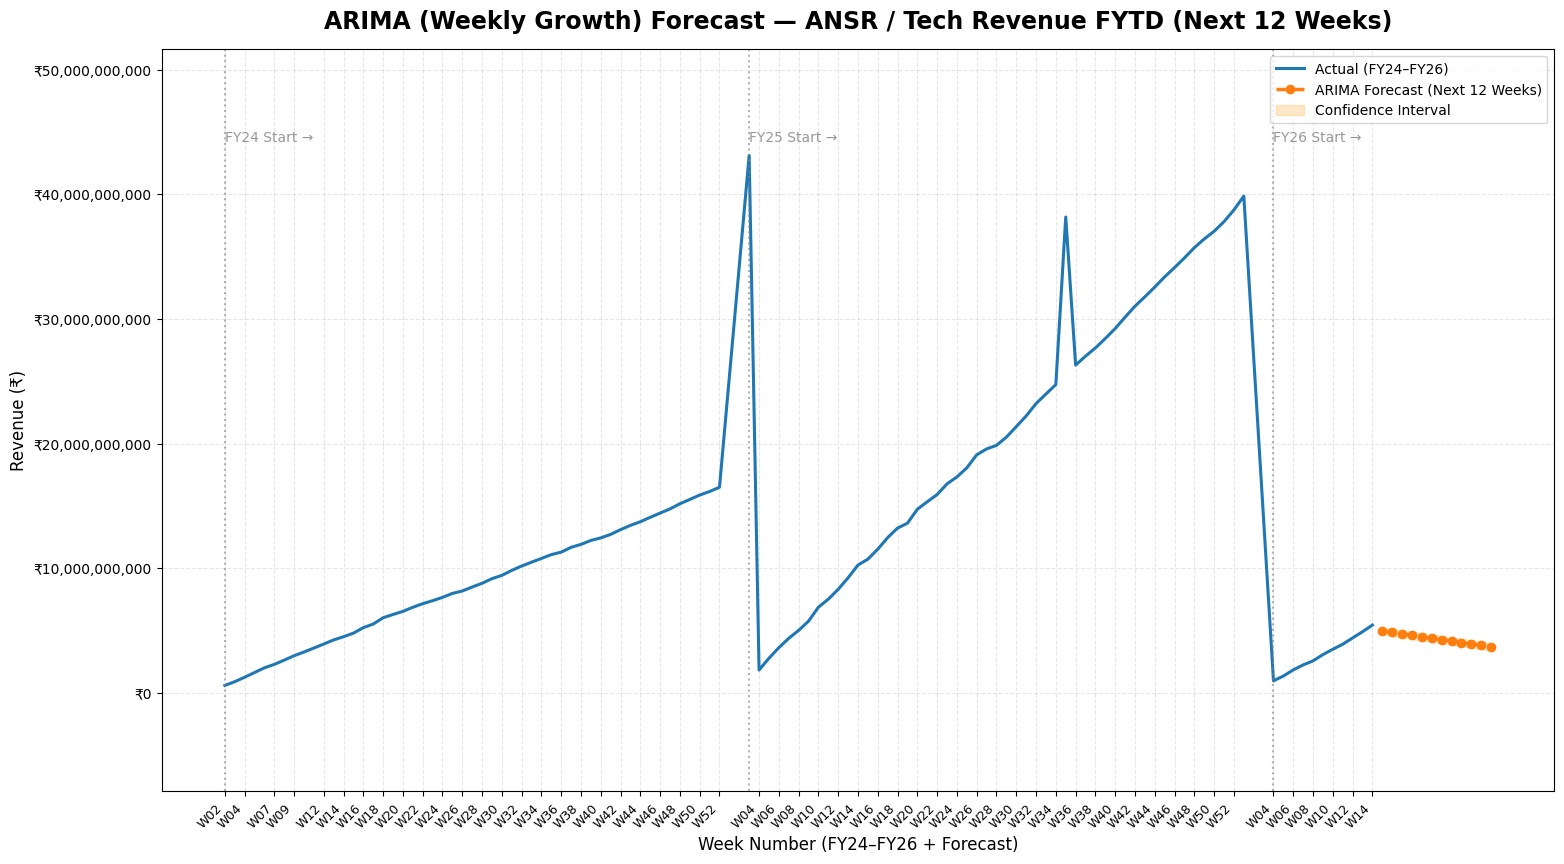


📋 ARIMA 12-Week Forecast Table:

   Date     Week  Predicted FYTD Revenue (₹)
2026-04-06   15        4,978,246,269.29     
2026-04-13   16        4,850,809,946.84     
2026-04-20   17        4,726,258,741.87     
2026-04-27   18        4,611,049,325.36     
2026-05-04   19        4,496,757,478.13     
2026-05-11   20        4,382,802,553.06     
2026-05-18   21        4,268,902,885.41     
2026-05-25   22        4,155,017,359.75     
2026-06-01   23        4,041,134,609.64     
2026-06-08   24        3,927,252,494.10     
2026-06-15   25        3,813,370,511.16     
2026-06-22   26        3,699,488,557.42     

✅ Forecast table displayed successfully.


In [12]:
# =========================================================
# 📈 ARIMA MODEL — Weekly Growth Forecast (FYTD Revenue)
# =========================================================

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# === 1️⃣ PREPARE WEEKLY TIME SERIES =======================
full_df = pd.concat([train_df, test_df], ignore_index=True)

weekly_data = (
    full_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Week"])
)

# Create numeric year & proper weekly date
weekly_data["Year_Num"] = (
    weekly_data["Year"].astype(str).str.extract(r"(\d+)")[0].astype(int) + 2000
)
weekly_data["Date"] = pd.to_datetime(
    weekly_data["Year_Num"].astype(str) + weekly_data["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)
weekly_data = weekly_data.sort_values("Date").set_index("Date")

# Convert FYTD → Weekly Increment series
weekly_data["Weekly_Increment"] = weekly_data["ANSR / Tech Revenue FYTD"].diff().fillna(0)
ts_weekly = weekly_data["Weekly_Increment"]

# === 2️⃣ TRAIN ARIMA MODEL ================================
model = ARIMA(ts_weekly, order=(2, 1, 2))
fitted_model = model.fit()
print("✅ ARIMA Model Fitted Successfully!")

# === 3️⃣ FORECAST NEXT 12 WEEKS ===========================
forecast_steps = 12
forecast_result = fitted_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Future weekly dates
last_date = ts_weekly.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=forecast_steps, freq="W-MON")

# Forecast DataFrame
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Weekly Growth": forecast_mean.values,
    "Lower CI": conf_int.iloc[:, 0].values,
    "Upper CI": conf_int.iloc[:, 1].values
}).set_index("Date")

# Convert back to FYTD-level forecast
latest_fytd_value = weekly_data["ANSR / Tech Revenue FYTD"].iloc[-1]
forecast_df["Predicted FYTD Revenue (₹)"] = latest_fytd_value + forecast_df["Predicted Weekly Growth"].cumsum()

# Add Week numbers
forecast_df["Week"] = forecast_df.index.isocalendar().week

# === 4️⃣ EVALUATE MODEL PERFORMANCE =======================
split_idx = int(len(ts_weekly) * 0.8)
y_train, y_test = ts_weekly.iloc[:split_idx], ts_weekly.iloc[split_idx:]
pred_test = fitted_model.predict(start=y_test.index[0], end=y_test.index[-1])

rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mae = mean_absolute_error(y_test, pred_test)
mape = np.mean(np.abs((y_test - pred_test) / np.maximum(np.abs(y_test), 1e-9))) * 100
r2 = r2_score(y_test, pred_test)
accuracy = 100 - mape

# === 5️⃣ PRINT PERFORMANCE SUMMARY ========================
print("\n📊 ARIMA Model Performance Metrics (Weekly Increment Series)")
print("------------------------------------------------------------")
print(f"   RMSE   : {rmse:,.2f}")
print(f"   MAE    : {mae:,.2f}")
print(f"   MAPE   : {mape:.2f}%")
print(f"   R²     : {r2:.4f}")
print(f"   Accuracy (≈ 100 - MAPE): {accuracy:.2f}%")

# === 6️⃣ PLOT ACTUAL vs FORECAST ==========================
plt.figure(figsize=(16,9))

# Actual FYTD values
plt.plot(
    weekly_data.index,
    weekly_data["ANSR / Tech Revenue FYTD"],
    label="Actual (FY24–FY26)",
    color="#1f77b4",
    linewidth=2.2
)

# Forecasted FYTD
plt.plot(
    forecast_df.index,
    forecast_df["Predicted FYTD Revenue (₹)"],
    label="ARIMA Forecast (Next 12 Weeks)",
    color="#ff7f0e",
    linestyle="--",
    marker='o',
    linewidth=2.5
)

# Confidence Interval shading
plt.fill_between(
    forecast_df.index,
    forecast_df["Predicted FYTD Revenue (₹)"] - (forecast_df["Predicted Weekly Growth"].std()*3),
    forecast_df["Predicted FYTD Revenue (₹)"] + (forecast_df["Predicted Weekly Growth"].std()*3),
    color="#ffb347",
    alpha=0.3,
    label="Confidence Interval"
)

# X-axis formatting (every 2 weeks)
tick_idx = weekly_data.index[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha="right", fontsize=9)

# Fiscal Year markers
years = sorted(weekly_data["Year_Num"].unique())
for y in years:
    fy_weeks = weekly_data[weekly_data["Year_Num"] == y]
    if not fy_weeks.empty:
        start = fy_weeks.index.min()
        plt.axvline(start, color="gray", linestyle=":", alpha=0.6)
        plt.text(
            start, weekly_data["ANSR / Tech Revenue FYTD"].max() * 1.02,
            f"FY{y-2000} Start →",
            fontsize=10, color="gray", ha="left", va="bottom", alpha=0.8
        )

# Dynamic Y-axis limits
y_min = min(weekly_data["ANSR / Tech Revenue FYTD"].min(), forecast_df["Predicted FYTD Revenue (₹)"].min())
y_max = max(weekly_data["ANSR / Tech Revenue FYTD"].max(), forecast_df["Predicted FYTD Revenue (₹)"].max())
y_buffer = (y_max - y_min) * 0.2
plt.ylim(y_min - y_buffer, y_max + y_buffer)

# Formatting & Styling
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"₹{x:,.0f}"))
plt.title("ARIMA (Weekly Growth) Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)",
          fontsize=17, weight="bold", pad=15)
plt.xlabel("Week Number (FY24–FY26 + Forecast)", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout(pad=2)
plt.show()

# === 7️⃣ DISPLAY FULL FORECAST TABLE ======================
pd.options.display.float_format = '{:,.2f}'.format  # disable scientific notation globally

forecast_display = forecast_df.reset_index()[["Date", "Week", "Predicted FYTD Revenue (₹)"]]
forecast_display["Date"] = forecast_display["Date"].dt.strftime("%Y-%m-%d")

print("\n📋 ARIMA 12-Week Forecast Table:\n")
print(forecast_display.to_string(index=False, justify="center"))
print("\n✅ Forecast table displayed successfully.")


09:52:07 - cmdstanpy - INFO - Chain [1] start processing
09:52:07 - cmdstanpy - INFO - Chain [1] done processing


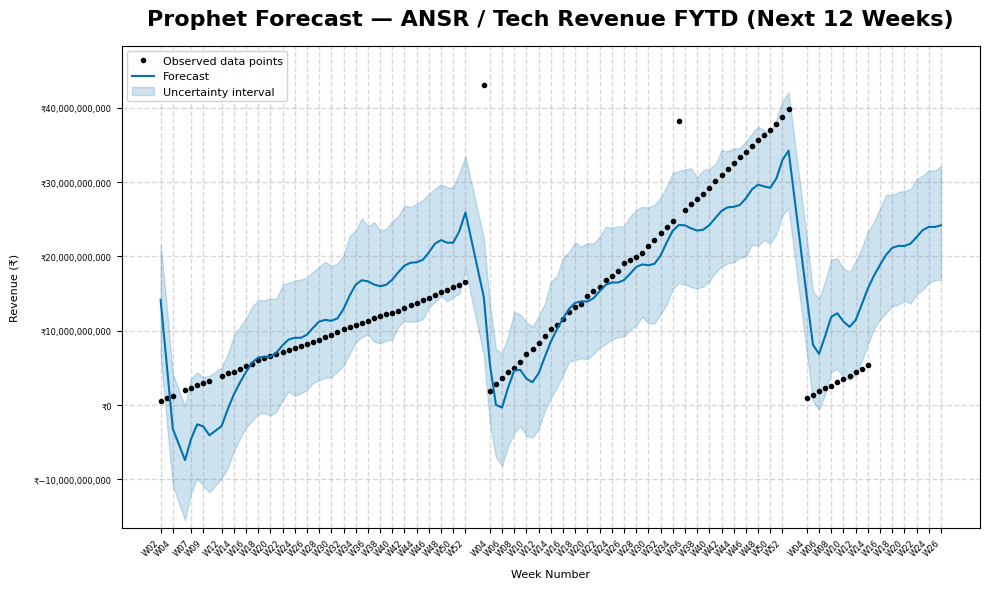


📅 12-Week Prophet Forecast — ANSR / Tech Revenue FYTD

Week Fiscal Year Predicted FYTD (₹)
W15      FY26     ₹17,396,589,180  
W16      FY26     ₹18,866,166,058  
W17      FY26     ₹20,216,684,223  
W18      FY26     ₹21,153,805,693  
W19      FY26     ₹21,434,571,351  
W20      FY26     ₹21,403,312,002  
W21      FY26     ₹21,724,388,142  
W22      FY26     ₹22,604,562,645  
W23      FY26     ₹23,540,950,928  
W24      FY26     ₹23,964,628,544  
W25      FY26     ₹23,970,298,877  
W26      FY26     ₹24,192,064,154  


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import matplotlib.ticker as mtick

# === 1️⃣ Prepare Data ===
prophet_df = (
    weekly_data.reset_index()[["Date", "ANSR / Tech Revenue FYTD"]]
    .rename(columns={"Date": "ds", "ANSR / Tech Revenue FYTD": "y"})
    .dropna()
)

# === 2️⃣ Fit Prophet ===
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)
m.fit(prophet_df)

# === 3️⃣ Forecast Next 12 Weeks ===
future = m.make_future_dataframe(periods=12, freq='W-MON')
forecast = m.predict(future)

# === 4️⃣ Plot Clean Forecast Chart ===
fig = m.plot(forecast)
ax = fig.gca()

plt.title("Prophet Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)", fontsize=16, weight="bold", pad=15)
plt.xlabel("Week Number", fontsize=8, labelpad=8)
plt.ylabel("Revenue (₹)", fontsize=8, labelpad=10)
plt.yticks(fontsize=6)

# ✅ Format Y-axis
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.0f}'))

# ✅ Custom X-axis Week Labels (W##)
tick_idx = forecast["ds"].iloc[::2]
week_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=week_labels, rotation=45, ha='right', fontsize=6)

plt.grid(alpha=0.3, linestyle='--')
ymin, ymax = ax.get_ylim()
plt.ylim(ymin * 0.9, ymax * 1.05)

legend = plt.legend(frameon=True, fontsize=8, loc='upper left')
legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.show()

# === 5️⃣ Extract Next 12 Weeks Forecasted Values ===
forecast_tail = forecast.tail(12).copy()

# Compute fiscal year and week number
forecast_tail["Week_Number"] = forecast_tail["ds"].dt.isocalendar().week
forecast_tail["Fiscal_Year"] = forecast_tail["ds"].dt.year
forecast_tail["FY_Label"] = forecast_tail["Fiscal_Year"].apply(lambda x: f"FY{x-2000}")
forecast_tail["Week_Label"] = forecast_tail["Week_Number"].apply(lambda w: f"W{int(w):02d}")

# === 6️⃣ Select and Format Relevant Columns ===
table = forecast_tail[["Week_Label", "FY_Label", "yhat"]].copy()

# Format currency neatly
table["yhat"] = table["yhat"].apply(lambda x: f"₹{x:,.0f}")

# Rename columns for readability
table.columns = [
    "Week", "Fiscal Year", "Predicted FYTD (₹)"
]

# === 7️⃣ Print Forecast Table ===
print("\n📅 12-Week Prophet Forecast — ANSR / Tech Revenue FYTD\n")
print(table.to_string(index=False, justify="center"))


In [16]:
# ===============================================
# 🔮 CREATE POWER BI INPUT TABLE (PREDICTED REVENUE)
# ===============================================

# Prepare predicted FYTD data from forecast_df
forecast_powerbi = forecast_df.copy().reset_index()

# Extract Fiscal Year & Week Number
forecast_powerbi["Fiscal Year"] = forecast_powerbi["Date"].dt.year
forecast_powerbi["Week Number"] = forecast_powerbi["Date"].dt.isocalendar().week

# Add a Market Segment column placeholder (optional)
# You can fill it later with actual segment info if available
forecast_powerbi["Market Segment"] = "Yet to Update"

# Keep consistent column order with actual table
forecast_powerbi = forecast_powerbi[[
    "Market Segment", "Fiscal Year", "Week Number", "Predicted FYTD"
]]

# Rename for clarity and consistency
# forecast_powerbi.rename(columns={
#     "Predicted FYTD": "Revenue FYTD"
# }, inplace=True)

# Ensure full numeric display
pd.set_option("display.float_format", "{:.0f}".format)

# Preview first few rows
print(forecast_powerbi.head(20))

# ✅ Optional: Export to CSV for Power BI
# forecast_powerbi.to_csv("PowerBI_Predicted_Revenue.csv", index=False)


   Market Segment  Fiscal Year  Week Number  Predicted FYTD
0   Yet to Update         2026           15      5966903871
1   Yet to Update         2026           16      6683946754
2   Yet to Update         2026           17      7062232893
3   Yet to Update         2026           18      7529707926
4   Yet to Update         2026           19      8059662865
5   Yet to Update         2026           20      8593967263
6   Yet to Update         2026           21      8922797296
7   Yet to Update         2026           22      9617746979
8   Yet to Update         2026           23     10012464992
9   Yet to Update         2026           24     10396434415
10  Yet to Update         2026           25     10916449805
11  Yet to Update         2026           26     11305836379


In [25]:
# ===============================================
# 🔮 CREATE POWER BI INPUT TABLE (WEEK + PREDICTED VALUE ONLY)
# ===============================================

# Prepare predicted FYTD data from forecast_df
forecast_powerbi = forecast_df.copy().reset_index()

# Extract Fiscal Week Number
forecast_powerbi["Week Number"] = forecast_powerbi["Date"].dt.isocalendar().week
forecast_powerbi["Week_Label"] = forecast_powerbi["Week Number"].apply(lambda w: f"W{int(w):02d}")

# Keep only Week and Predicted FYTD columns
forecast_powerbi = forecast_powerbi[["Week_Label", "Predicted FYTD"]].copy()

# Format FYTD values as ₹ currency (optional)
forecast_powerbi["Predicted FYTD"] = forecast_powerbi["Predicted FYTD"].apply(lambda x: f"₹{x:,.0f}")

# Rename columns for Power BI clarity
forecast_powerbi.columns = ["Fiscal Week", "Predicted FYTD (₹)"]

# Preview first few rows
print("\n📊 Power BI Input — Predicted Revenue by Week\n")
print(forecast_powerbi.head(20).to_string(index=False, justify="center"))

# ✅ Optional: Export to CSV for Power BI
# forecast_powerbi.to_csv("PowerBI_Predicted_Revenue.csv", index=False)



📊 Power BI Input — Predicted Revenue by Week

Fiscal Week Predicted FYTD (₹)
    W15       ₹5,966,903,871  
    W16       ₹6,683,946,754  
    W17       ₹7,062,232,893  
    W18       ₹7,529,707,926  
    W19       ₹8,059,662,865  
    W20       ₹8,593,967,263  
    W21       ₹8,922,797,296  
    W22       ₹9,617,746,979  
    W23      ₹10,012,464,992  
    W24      ₹10,396,434,415  
    W25      ₹10,916,449,805  
    W26      ₹11,305,836,379  


✅ SARIMA Model Fitted Successfully!

📊 SARIMA Model Performance Metrics (Weekly Increment Series)
------------------------------------------------------------
   RMSE   : 10,783,414,139.19
   MAE    : 3,605,355,614.92
   MAPE   : 399.98%
   R²     : -0.7878
   Accuracy (≈ 100 - MAPE): -299.98%

📈 Classification Metrics (Trend Direction — Up vs Down)
------------------------------------------------------------
   Precision : 0.9500
   Recall    : 0.8636
   F1-Score  : 0.9048

🧮 Confusion Matrix:
          Pred ↓  Pred ↑
Actual ↓       0       1
Actual ↑       3      19


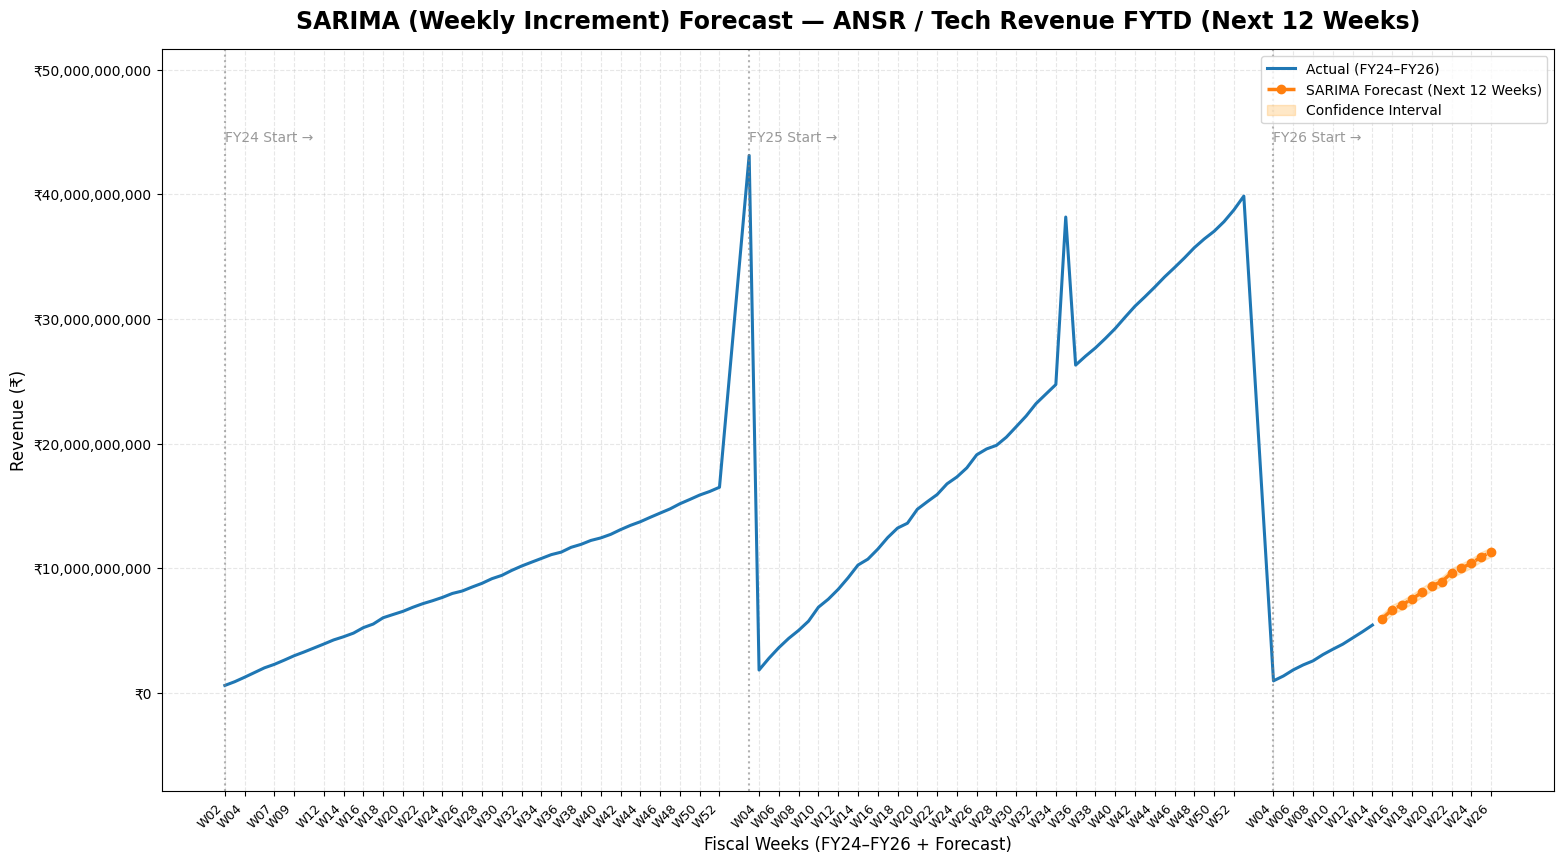


📅 12-Week SARIMA Forecast — ANSR / Tech Revenue FYTD

Fiscal Week Fiscal Year Predicted FYTD (₹)
    W15         FY26      ₹5,966,903,871  
    W16         FY26      ₹6,683,946,754  
    W17         FY26      ₹7,062,232,893  
    W18         FY26      ₹7,529,707,926  
    W19         FY26      ₹8,059,662,865  
    W20         FY26      ₹8,593,967,263  
    W21         FY26      ₹8,922,797,296  
    W22         FY26      ₹9,617,746,979  
    W23         FY26     ₹10,012,464,992  
    W24         FY26     ₹10,396,434,415  
    W25         FY26     ₹10,916,449,805  
    W26         FY26     ₹11,305,836,379  


In [24]:
# =========================================================
# 📈 SARIMA MODEL — Weekly Revenue Increment Forecasting
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    confusion_matrix, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings("ignore")

# === 1️⃣ DATA PREPARATION =================================

# Combine training and test data
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Aggregate revenue by Year & Week
weekly_data = (
    full_df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
    .sum()
    .reset_index()
    .sort_values(["Year", "Week"])
)

# Convert "Year" → numeric and create proper date
weekly_data["Year_Num"] = (
    weekly_data["Year"].astype(str).str.extract(r"(\d+)")[0].astype(int) + 2000
)
weekly_data["Date"] = pd.to_datetime(
    weekly_data["Year_Num"].astype(str) + weekly_data["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

weekly_data = weekly_data.sort_values("Date").set_index("Date")

# Create weekly increment column (difference week-to-week)
weekly_data["Weekly_Increment"] = weekly_data["ANSR / Tech Revenue FYTD"].diff().fillna(0)
ts_weekly = weekly_data["Weekly_Increment"]

# === 2️⃣ TRAIN SARIMA MODEL ===============================

sarima_model = SARIMAX(
    ts_weekly,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 52),  # annual seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fitted = sarima_model.fit(disp=False)
print("✅ SARIMA Model Fitted Successfully!")

# === 3️⃣ FORECAST NEXT 12 WEEKS ===========================

forecast_steps = 12
sarima_forecast = sarima_fitted.get_forecast(steps=forecast_steps)
forecast_mean = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

# Create weekly future dates
future_dates = pd.date_range(
    start=ts_weekly.index[-1] + pd.Timedelta(days=7),
    periods=forecast_steps,
    freq="W-MON"
)

forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Weekly Growth": forecast_mean.values,
    "Lower CI": conf_int.iloc[:, 0].values,
    "Upper CI": conf_int.iloc[:, 1].values
}).set_index("Date")

# Convert weekly growth → FYTD forecast
latest_fytd_value = weekly_data["ANSR / Tech Revenue FYTD"].iloc[-1]
forecast_df["Predicted FYTD"] = latest_fytd_value + forecast_df["Predicted Weekly Growth"].cumsum()

# === 4️⃣ MODEL EVALUATION (REGRESSION METRICS) ============

split_idx = int(len(ts_weekly) * 0.8)
y_train, y_test = ts_weekly.iloc[:split_idx], ts_weekly.iloc[split_idx:]
pred_test = sarima_fitted.predict(start=y_test.index[0], end=y_test.index[-1])

rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mae = mean_absolute_error(y_test, pred_test)
mape = np.mean(np.abs((y_test - pred_test) / np.maximum(np.abs(y_test), 1e-9))) * 100
r2 = r2_score(y_test, pred_test)
accuracy = 100 - mape

# === 5️⃣ CLASSIFICATION METRICS (UP/DOWN TREND) ===========

y_test_dir = (y_test > 0).astype(int)
pred_test_dir = (pred_test > 0).astype(int)

cm = confusion_matrix(y_test_dir, pred_test_dir)
precision = precision_score(y_test_dir, pred_test_dir, zero_division=0)
recall = recall_score(y_test_dir, pred_test_dir, zero_division=0)
f1 = f1_score(y_test_dir, pred_test_dir, zero_division=0)

# === 6️⃣ PERFORMANCE SUMMARY ===============================

print("\n📊 SARIMA Model Performance Metrics (Weekly Increment Series)")
print("------------------------------------------------------------")
print(f"   RMSE   : {rmse:,.2f}")
print(f"   MAE    : {mae:,.2f}")
print(f"   MAPE   : {mape:.2f}%")
print(f"   R²     : {r2:.4f}")
print(f"   Accuracy (≈ 100 - MAPE): {accuracy:.2f}%")

print("\n📈 Classification Metrics (Trend Direction — Up vs Down)")
print("------------------------------------------------------------")
print(f"   Precision : {precision:.4f}")
print(f"   Recall    : {recall:.4f}")
print(f"   F1-Score  : {f1:.4f}")
print("\n🧮 Confusion Matrix:")
print(pd.DataFrame(cm, index=["Actual ↓", "Actual ↑"], columns=["Pred ↓", "Pred ↑"]))

# === 7️⃣ VISUALIZE FORECAST (FYTD LEVEL with Weeks) ==================
plt.figure(figsize=(16,9))

plt.plot(
    weekly_data.index,
    weekly_data["ANSR / Tech Revenue FYTD"],
    label="Actual (FY24–FY26)",
    color="#1f77b4",
    linewidth=2.2
)

plt.plot(
    forecast_df.index,
    forecast_df["Predicted FYTD"],
    label="SARIMA Forecast (Next 12 Weeks)",
    color="#ff7f0e",
    linestyle="--",
    marker='o',
    linewidth=2.5
)

plt.fill_between(
    forecast_df.index,
    forecast_df["Predicted FYTD"] - (forecast_df["Predicted Weekly Growth"].std()*3),
    forecast_df["Predicted FYTD"] + (forecast_df["Predicted Weekly Growth"].std()*3),
    color="#ffb347",
    alpha=0.3,
    label="Confidence Interval"
)

# Combine actual + forecast dates for x-axis labels
all_dates = pd.concat([weekly_data, forecast_df], axis=0).index
week_labels = [f"W{d.isocalendar().week:02d}" for d in all_dates]

plt.xticks(
    ticks=all_dates[::2],
    labels=week_labels[::2],
    rotation=45,
    ha="right",
    fontsize=9
)

# Fiscal Year markers
years = sorted(weekly_data["Year_Num"].unique())
for y in years:
    fy_weeks = weekly_data[weekly_data["Year_Num"] == y]
    if not fy_weeks.empty:
        start = fy_weeks.index.min()
        plt.axvline(start, color="gray", linestyle=":", alpha=0.6)
        plt.text(
            start,
            weekly_data["ANSR / Tech Revenue FYTD"].max() * 1.02,
            f"FY{y-2000} Start →",
            fontsize=10, color="gray", ha="left", va="bottom", alpha=0.8
        )

# Adjust Y-axis
y_min = min(weekly_data["ANSR / Tech Revenue FYTD"].min(), forecast_df["Predicted FYTD"].min())
y_max = max(weekly_data["ANSR / Tech Revenue FYTD"].max(), forecast_df["Predicted FYTD"].max())
y_buffer = (y_max - y_min) * 0.2
plt.ylim(y_min - y_buffer, y_max + y_buffer)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"₹{x:,.0f}"))
plt.title(
    "SARIMA (Weekly Increment) Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)",
    fontsize=17, weight="bold", pad=15
)
plt.xlabel("Fiscal Weeks (FY24–FY26 + Forecast)", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout(pad=2)
plt.show()

# =========================================================
# === 🔟 Clean & Readable Forecast Table (Simplified) ===

forecast_pretty = forecast_df.copy()

# Extract fiscal week number and year
forecast_pretty["Week_Number"] = forecast_pretty.index.isocalendar().week
forecast_pretty["Fiscal_Year"] = forecast_pretty.index.year
forecast_pretty["FY_Label"] = forecast_pretty["Fiscal_Year"].apply(lambda x: f"FY{x-2000}")
forecast_pretty["Week_Label"] = forecast_pretty["Week_Number"].apply(lambda w: f"W{int(w):02d}")

# Format ₹ values for FYTD column only
forecast_pretty["Predicted FYTD"] = forecast_pretty["Predicted FYTD"].apply(lambda x: f"₹{x:,.0f}")

# Reset index and select only needed columns
forecast_pretty = forecast_pretty.reset_index(drop=True)[[
    "Week_Label", "FY_Label", "Predicted FYTD"
]]

# Rename columns
forecast_pretty.columns = [
    "Fiscal Week", "Fiscal Year", "Predicted FYTD (₹)"
]

# === Display final clean table ===
print("\n📅 12-Week SARIMA Forecast — ANSR / Tech Revenue FYTD\n")
print(forecast_pretty.to_string(index=False, justify="center"))


In [28]:
# =========================================================
# 🧭 INTERACTIVE SARIMA FORECAST PLOT (Using Plotly)
# =========================================================

import plotly.graph_objects as go
import pandas as pd
import numpy as np

# === Compute confidence interval bounds ===
upper_bound = forecast_df["Predicted FYTD"] + forecast_df["Predicted Weekly Growth"].std() * 3
lower_bound = forecast_df["Predicted FYTD"] - forecast_df["Predicted Weekly Growth"].std() * 3

# === Create figure ===
fig = go.Figure()

# 1️⃣ Actual FYTD Series
fig.add_trace(go.Scatter(
    x=weekly_data.index,
    y=weekly_data["ANSR / Tech Revenue FYTD"],
    mode='lines',
    name='Actual (FY24–FY26)',
    line=dict(color='#1f77b4', width=2.2),
    hovertemplate='<b>Week:</b> %{x|%Y-%W}<br><b>Actual:</b> ₹%{y:,.0f}<extra></extra>'
))

# 2️⃣ Forecasted FYTD Series
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Predicted FYTD"],
    mode='lines+markers',
    name='SARIMA Forecast (Next 12 Weeks)',
    line=dict(color='#ff7f0e', dash='dash', width=2.5),
    marker=dict(size=6, symbol='circle'),
    hovertemplate='<b>Forecast Week:</b> %{x|%Y-%W}<br><b>Predicted:</b> ₹%{y:,.0f}<extra></extra>'
))

# 3️⃣ Confidence Interval (±3σ)
fig.add_trace(go.Scatter(
    x=list(forecast_df.index) + list(forecast_df.index[::-1]),
    y=list(upper_bound) + list(lower_bound[::-1]),
    fill='toself',
    fillcolor='rgba(255,179,71,0.25)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Confidence Interval (±3σ)',
    hoverinfo='skip',
    showlegend=True
))

# === Fiscal Week Labels (FYxx W##) ===
all_dates = pd.concat([weekly_data, forecast_df], axis=0).index
week_labels = [f"FY{d.year-2000} W{d.isocalendar().week:02d}" for d in all_dates]

# === Update layout for better aesthetics ===
fig.update_layout(
    title={
        'text': "SARIMA (Weekly Increment) Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=17, family='Arial', color='#333')
    },
    xaxis=dict(
        title="Fiscal Weeks (FY24–FY26 + Forecast)",
        tickmode='array',
        tickvals=all_dates[::2],
        ticktext=week_labels[::2],
        showgrid=True,
        gridcolor='rgba(200,200,200,0.3)'
    ),
    yaxis=dict(
        title="Revenue (₹)",
        tickprefix="₹",
        showgrid=True,
        gridcolor='rgba(200,200,200,0.3)'
    ),
    legend=dict(
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='rgba(0,0,0,0.1)',
        borderwidth=1,
        font=dict(size=10)
    ),
    hovermode='x unified',
    template='plotly_white',
    width=1150,
    height=600,
    margin=dict(l=70, r=40, t=80, b=80)
)

# === Show interactive figure ===
fig.show(renderer="browser")



In [35]:
# =========================================================
# 🧭 INTERACTIVE SARIMA FORECAST PLOT (Clean Labels Version)
# =========================================================

import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.io as pio

# (Optional) Ensure proper rendering in VS Code Jupyter
pio.renderers.default = "notebook_connected"

# === Compute confidence interval bounds ===
upper_bound = forecast_df["Predicted FYTD"] + forecast_df["Predicted Weekly Growth"].std() * 3
lower_bound = forecast_df["Predicted FYTD"] - forecast_df["Predicted Weekly Growth"].std() * 3

# === Create figure ===
fig = go.Figure()

# 1️⃣ Actual FYTD Series
fig.add_trace(go.Scatter(
    x=weekly_data.index,
    y=weekly_data["ANSR / Tech Revenue FYTD"],
    mode='lines',
    name='Actual (FY24–FY26)',
    line=dict(color='#1f77b4', width=2.2),
    hovertemplate='<b>Week:</b> %{x|%Y-%W}<br><b>Actual:</b> ₹%{y:,.0f}<extra></extra>'
))

# 2️⃣ Forecasted FYTD Series
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Predicted FYTD"],
    mode='lines+markers',
    name='SARIMA Forecast (Next 12 Weeks)',
    line=dict(color='#ff7f0e', dash='dash', width=2.5),
    marker=dict(size=6, symbol='circle'),
    hovertemplate='<b>Forecast Week:</b> %{x|%Y-%W}<br><b>Predicted:</b> ₹%{y:,.0f}<extra></extra>'
))

# 3️⃣ Confidence Interval (±3σ)
fig.add_trace(go.Scatter(
    x=list(forecast_df.index) + list(forecast_df.index[::-1]),
    y=list(upper_bound) + list(lower_bound[::-1]),
    fill='toself',
    fillcolor='rgba(255,179,71,0.25)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Confidence Interval (±3σ)',
    hoverinfo='skip',
    showlegend=True
))

# === Week labels (Remove FY prefix, keep W## only) ===
all_dates = pd.concat([weekly_data, forecast_df], axis=0).index
week_labels = [f"W{d.isocalendar().week:02d}" for d in all_dates]

# === Update layout ===
fig.update_layout(
    title={
        'text': "SARIMA (Weekly Increment) Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=17, family='Arial', color='#333')
    },
    xaxis=dict(
        title="Fiscal Weeks (FY24–FY26 + Forecast)",
        tickmode='array',
        tickvals=all_dates[::2],
        ticktext=week_labels[::2],  # ✅ only week numbers
        showgrid=True,
        gridcolor='rgba(200,200,200,0.3)'
    ),
    yaxis=dict(
        title="Revenue (₹)",
        tickformat=",",  # ✅ show full number (no K/M/B suffix)
        showgrid=True,
        gridcolor='rgba(200,200,200,0.3)'
    ),
    legend=dict(
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='rgba(0,0,0,0.1)',
        borderwidth=1,
        font=dict(size=10)
    ),
    hovermode='x unified',
    template='plotly_white',
    width=1150,
    height=600,
    margin=dict(l=70, r=40, t=80, b=80)
)

# === Show the figure ===
fig.show(renderer="browser")



In [31]:
test_df.tail()

,ANSR / Tech Revenue FYTD,AR Outstanding,Billed Expenses FYTD,Billed Fees FYTD,Billed Revenue Days,Charged Hours FYTD,Client,Client ID,EAF Reserve FYTD,ETD Total Collections,...,FYTD Labor Costs,FYTD Unbilled Expenses,Location,MS,NUI ETD,Total Billed FYTD,Unbilled Revenue Days,Month,Week,Year
278937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Bangalore,TMT,NaN,NaN,NaN,SEP,13,FY26
278938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Chennai,TMT,NaN,NaN,NaN,SEP,13,FY26
278939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Delhi,TMT,NaN,NaN,NaN,SEP,13,FY26
278940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Hyderabad,TMT,NaN,NaN,NaN,SEP,13,FY26
278941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Mumbai,TMT,NaN,NaN,NaN,SEP,13,FY26
